# Processing

This notebook tries several processing methods on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = '/Users/vug/Downloads/movie_metadata.csv'
filepath = r'C:\Users\veliu\Downloads\movie_metadata.csv'

# Drop some columns

In [3]:
df = pd.read_csv(filepath)

# Drop features
to_drop = ['country', 'language', 'movie_imdb_link']
df.drop(to_drop, axis=1, inplace=True)

# Impute dataset, fill null values

A table that indicates the number of missing values in each column.

In [4]:
null_counts = [(col, df[col].isnull().sum()) for col in df]
pd.DataFrame(null_counts, columns=['feature', 'null_cnt']).sort_values(by='null_cnt', ascending=False)

,feature,null_cnt
8,gross,884
19,budget,492
23,aspect_ratio,329
18,content_rating,303
16,plot_keywords,153
20,title_year,108
1,director_name,104
4,director_facebook_likes,104
2,num_critic_for_reviews,50
5,actor_3_facebook_likes,23


- For numeric values, fill nulls with the median
- for categorical, fill nulls with the most common value of that category

In [5]:
features_text = sorted(df.dtypes[df.dtypes == 'object'].index.values.tolist())
features_numeric = sorted(set(df.columns) - set(features_text))

In [6]:
def get_all_items_and_most_common(series):
    nested_list = series.apply(lambda x: x.split('|') if not type(x) == float else []).values
    all_items = pd.Series(np.hstack(nested_list))
    unique_items = all_items.unique()
    return sorted(unique_items), all_items.value_counts().index[0]

In [7]:
keywords, mc_keyword = get_all_items_and_most_common(df.plot_keywords)
genres, mc_genre = get_all_items_and_most_common(df.genres)
directors, mc_director = get_all_items_and_most_common(df.director_name)

In [8]:
for col in features_numeric:
    med = df[col].median()
    df[col].fillna(med, inplace=True)

In [9]:
for col in ['actor_1_name', 'actor_2_name', 'actor_3_name', 'color', 'content_rating', 'director_name']:
    most_common_value = df[col].value_counts().index[0]
    df[col].fillna(most_common_value, inplace=True)
df.plot_keywords.fillna(mc_keyword, inplace=True)

In [10]:
# no more nulls
len(df) - len(df.dropna())

0

# Feature Engineering

For plot_keywords, genres, actors, directors calculate average score given to the items.

In [12]:
def get_item_scores(df, items, column):
    item_scores = {item: [] for item in items}
    for ix, row in df.iterrows():
        if type(row[column]) == str:
            for item in row[column].split('|'):
                item_scores[item].append(row.imdb_score)
    return item_scores

In [13]:
keyword_scores = get_item_scores(df, keywords, 'plot_keywords')
genre_scores = get_item_scores(df, genres, 'genres')
director_scores = get_item_scores(df, directors, 'director_name')

In [14]:
all_actors = df.actor_1_name.values.tolist() + df.actor_2_name.values.tolist() + df.actor_3_name.values.tolist()
actors = sorted(set(all_actors))

actor_scores = {actor: [] for actor in actors}
for ix, row in df.iterrows():
    for a in [row.actor_1_name, row.actor_2_name, row.actor_3_name]:
        if type(a) == str:
            actor_scores[a].append(row.imdb_score)

In [15]:
def get_average_scores(scores):
    ave_scores = dict()
    for key, scores in scores.items():
        ave_scores[key] = sum(scores) / len(scores)
    return ave_scores

keyword_ave_scores = get_average_scores(keyword_scores)
genre_ave_scores = get_average_scores(genre_scores)
actor_ave_scores = get_average_scores(actor_scores)
director_ave_scores = get_average_scores(director_scores)

In [17]:
df.loc[:, 'actor_1_ave_score'] = df.actor_1_name.apply(lambda name: actor_ave_scores[name])
df.loc[:, 'actor_2_ave_score'] = df.actor_2_name.apply(lambda name: actor_ave_scores[name])
df.loc[:, 'actor_3_ave_score'] = df.actor_3_name.apply(lambda name: actor_ave_scores[name])
splitted = df.genres.apply(lambda s: s.split('|'))
df.loc[:, 'genres_ave_score'] = splitted.apply(lambda genres: sum([genre_ave_scores[g] for g in genres]) / len(genres))
splitted = df.plot_keywords.apply(lambda s: s.split('|'))
df.loc[:, 'keywords_ave_score'] = splitted.apply(lambda keywords: sum([keyword_ave_scores[k] for k in keywords]) / len(keywords))
df.loc[:, 'director_ave_score'] = df.director_name.apply(lambda name: director_ave_scores[name])

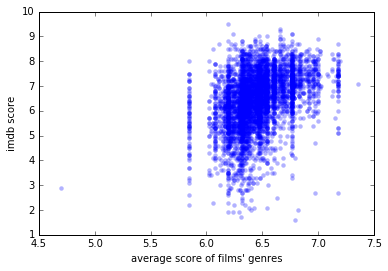

In [164]:
plt.scatter(df.genres_ave_score, df.imdb_score, lw=0, alpha=0.3)
plt.xlabel('average score of films\' genres')
plt.ylabel('imdb score');

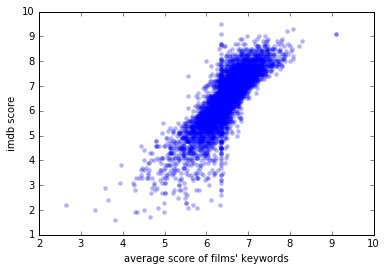

In [165]:
plt.scatter(df.keywords_ave_score, df.imdb_score, lw=0, alpha=0.3)
plt.xlabel('average score of films\' keywords')
plt.ylabel('imdb score');

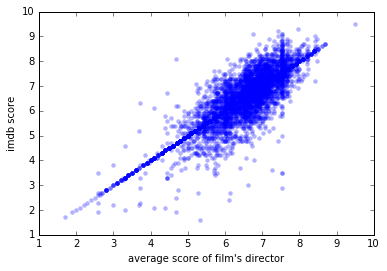

In [166]:
# For directors with only one movie, we have the straight line
plt.scatter(df.director_ave_score, df.imdb_score, lw=0, alpha=0.3)
plt.xlabel('average score of film\'s director')
plt.ylabel('imdb score');

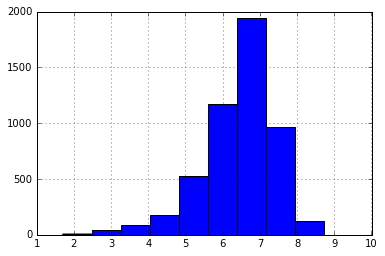

In [18]:
df.director_ave_score.hist()

# One Hot encoding for color and content_rating

They are categorical values, which can be included in our input by first converting to one hot encoding.

In [167]:
from sklearn import preprocessing

In [168]:
def label_encode_transform(series):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(series)
    return label_encoder.transform(series)

def one_hot_encode(series):
    one_hot_encoder = preprocessing.OneHotEncoder()
    inp = label_encode_transform(series)
    inp = inp.reshape(-1, 1)
    one_hot_encoder.fit(inp)
    one_hot = one_hot_encoder.transform(inp)
    return one_hot.toarray()

In [169]:
X_color = one_hot_encode(df.color)
X_rating = one_hot_encode(df.content_rating)

In [170]:
X_numeric = df[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
   'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews',
   'budget', 'title_year', 'actor_2_facebook_likes', 'actor_1_ave_score', 'actor_2_ave_score', 'actor_3_ave_score',
   'genres_ave_score', 'keywords_ave_score', 'director_ave_score']].values

# Combine all inputs

In [23]:
X = np.hstack([X_numeric, X_color, X_rating])
y = df.imdb_score.values

# Regression on the whole dataset

In [173]:
from sklearn import model_selection
from sklearn import linear_model

## Linear Regression

In [174]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

In [190]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
# mean square error
print('Linear regression error')
np.mean((regr.predict(X_test) - y_test) ** 2)

Linear regression error


0.14527224456891202

In [179]:
# base-line for mean-square error
np.mean((np.random.rand(len(y_test)) * 10. - y_test) ** 2)

11.537237559958207

If for each sample a random guess between 1 and 10 is given, then the mean square error becomes ~11. The model's error is ~0.1. It looks good!

In [181]:
def plot_actual_vs_prediction(predicted, actual):
    plt.figure(figsize=(5, 5))
    plt.scatter(predicted, actual, lw=0, alpha=0.5)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0, 10], [0, 10], color='red', lw=2, linestyle='--')
    plt.xlim([0, 10])
    plt.ylim([0, 10])

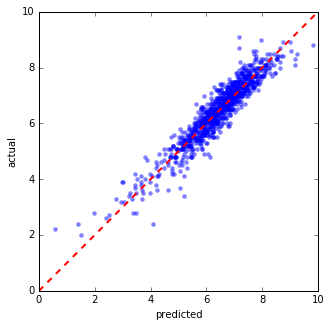

In [184]:
plot_actual_vs_prediction(regr.predict(X_test), y_test)

## K-Neighbors

In [185]:
from sklearn import neighbors

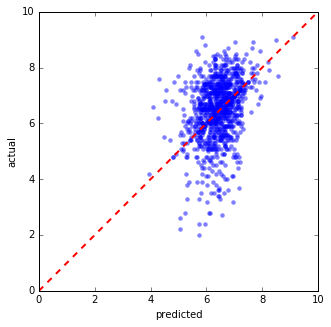

In [186]:
knr = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='kd_tree', leaf_size=60)
knr.fit(X_train, y_train)
plot_actual_vs_prediction(knr.predict(X_test), y_test)

In [188]:
print('K-Neighbors regression error')
np.mean((knr.predict(X_test) - y_test) ** 2)

K-Neighbors regression error


1.1860927924528561

## Random Forest

In [191]:
from sklearn import ensemble

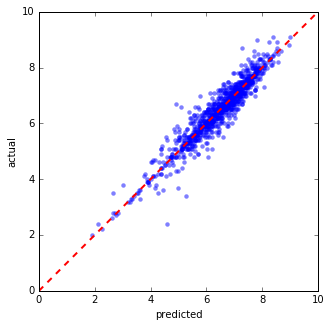

In [195]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, y_train)
plot_actual_vs_prediction(rfr.predict(X_test), y_test)

In [196]:
print('K-Neighbors regression error')
np.mean((rfr.predict(X_test) - y_test) ** 2)

K-Neighbors regression error


0.1218962338949455

In [197]:
# Try on the whole dataset
rfr = ensemble.RandomForestRegressor()
predicted = model_selection.cross_val_predict(rfr, X, y, cv=10)

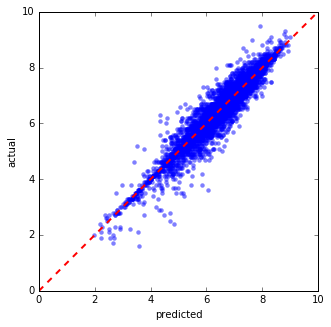

In [105]:
plot_actual_vs_prediction(predicted, y)

In [106]:
np.mean((predicted - y) ** 2)

0.12194043228237161

# PCA

Try PCA before training to reduce dimensionality.

In [107]:
from sklearn import decomposition

In [125]:
pca = decomposition.PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

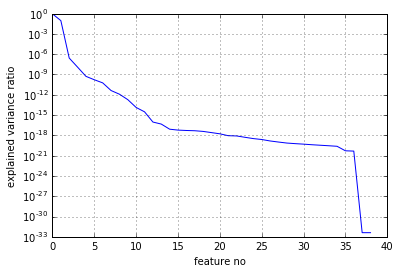

In [199]:
plt.semilogy(pca.explained_variance_ratio_)
plt.grid()
plt.xlabel('feature no')
plt.ylabel('explained variance ratio');

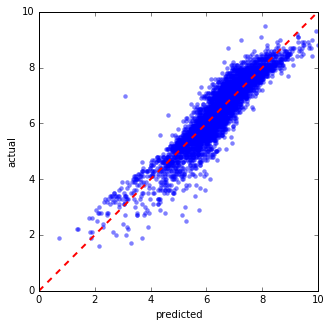

In [200]:
# Try fewer dimensions
X2 = pca.transform(X)[:, :15]
lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(lr, X2, y, cv=10)
plot_actual_vs_prediction(predicted, y)

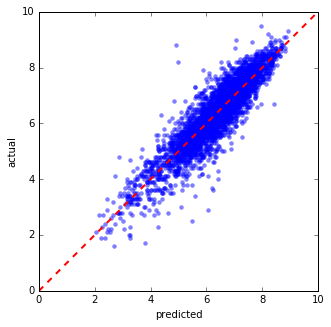

In [201]:
X2 = pca.transform(X)[:, :15]
rfr = ensemble.RandomForestRegressor()
predicted = model_selection.cross_val_predict(rfr, X2, y, cv=10)
plot_actual_vs_prediction(predicted, y)

# Commentary

- We developed a method for developing new features from plot keywords, genres, director and actor names. They helped a lot in predicting the IMDB score.
- The scores calculated on this notebook are misleading because we do our training and testing over whole dataset. Let's split training and test sets and train a model via training set and evaluate its prediction capacity over the test set.